# TD6. Introduction to Convolutional neural networks

#### Good Article to get a first introduction
https://github.com/nehal96/Deep-Learning-ND-Exercises/blob/master/Convolutional%20Neural%20Networks/convolutional-neural-networks-notes.md

How to prevent NN from overfitting

https://stackoverflow.com/questions/36139980/prevention-of-overfitting-in-convolutional-layers-of-a-cnn

#### A must read
https://arxiv.org/pdf/1709.01412.pdf

##### Reinforcement Learning

http://incompleteideas.net/book/bookdraft2017nov5.pdf

http://rail.eecs.berkeley.edu/deeprlcourse/index.html#related-materials

https://sites.google.com/view/deep-rl-bootcamp/lectures

In [1022]:
from IPython.display import Image

In [11]:
import numpy as np

In [27]:
X = np.array([[1,2],[2,2],[3,2]])

In [5]:
W = np.array([[4,4,17], [3,1,1]]) # Wji 

In [38]:
X

array([[1, 2],
       [2, 2],
       [3, 2]])

In [39]:
W = np.random.randint(-2,2, (2, 5))

In [45]:
W

array([[-2,  1, -1,  1, -1],
       [-1, -2,  0, -1, -2]])

In [41]:
np.dot(X,W)

array([[-4, -3, -1, -1, -5],
       [-6, -2, -2,  0, -6],
       [-8, -1, -3,  1, -7]])

In [52]:
np.dot(W.T, X.T)

array([[-4, -6, -8],
       [-3, -2, -1],
       [-1, -2, -3],
       [-1,  0,  1],
       [-5, -6, -7]])

In [278]:
import github_command as git

In [1643]:
git.push(file_to_transfer='td6_ressources/',
         message='TD6 - Added Scraper',
         repos='TDs_ESILV.git')

In [279]:
git.push(file_to_transfer='TD6_CNN.ipynb',
         message='TD6 - Added feature maps',
         repos='TDs_ESILV.git')

In [1]:
import os
import random
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
[x for x in os.listdir('./') if x.startswith('data')]

['data_dog',
 'data_cat',
 'data_odai',
 'data_zezette',
 'data_accidents',
 'data_meandbeardedones',
 'data_tekel',
 'data_hakitainu']

In [4]:
random.choices(os.listdir('data_dog'), k=3)

['4740.jpg', '939.jpg', '889.jpg']

## Checking images in directories

In [5]:
def show_k_images(path, k=3):
    import matplotlib.pyplot as plt
    from PIL import Image # used for loading images
    nb_cols = 2 if k%2 == 0 else 3
    fig, axes = plt.subplots(figsize=(nb_cols*5,k//nb_cols*5), nrows=k//nb_cols + k%nb_cols, ncols=nb_cols)
    for ax, (ax_number, choice) in zip(axes.flat, enumerate(random.choices(os.listdir(path), k=k))):
        ax.imshow(X=Image.open(path+choice))

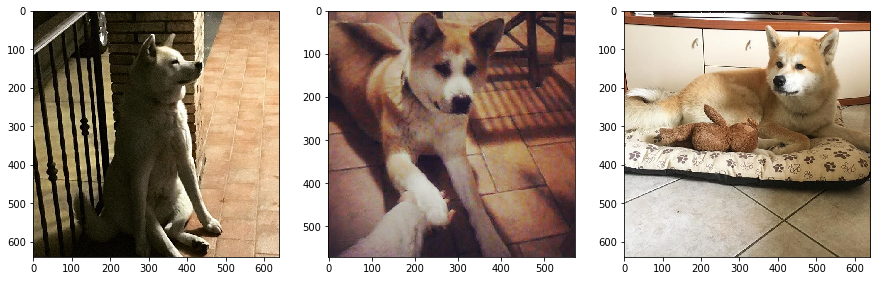

In [1506]:
show_k_images('data_hakitainu/', 3)

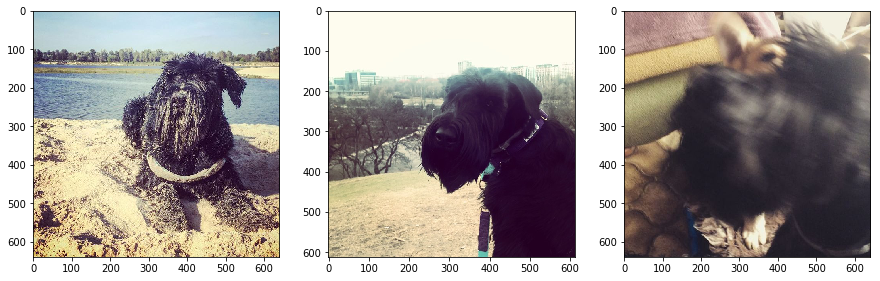

In [1501]:
show_k_images('data_meandbeardedones/', 3)

## Load data and (maybe) preprocess it

In [263]:
from PIL import Image # used for loading images

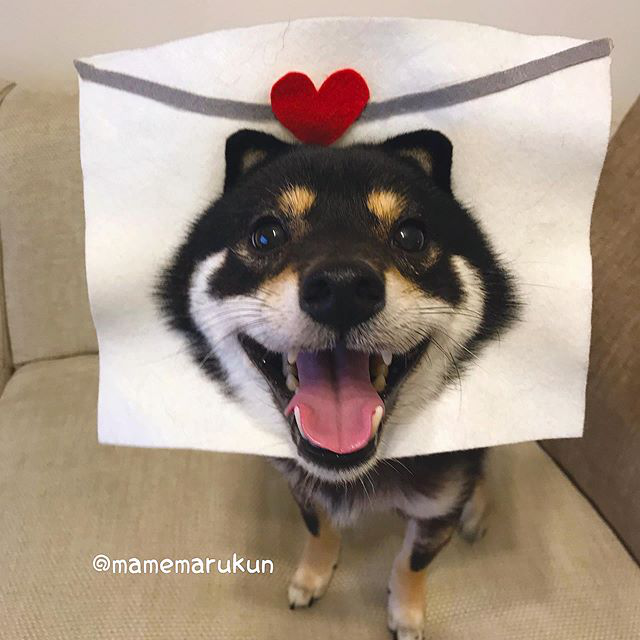

In [265]:
img = Image.open('data_dog/1.jpg')
img

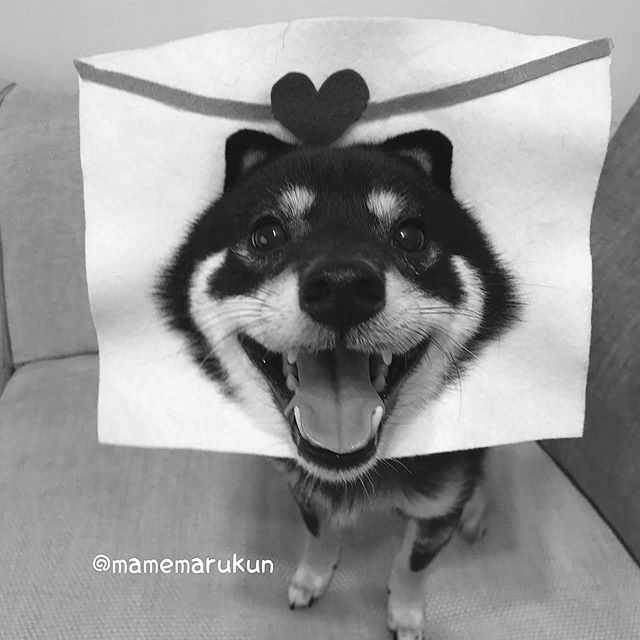

In [266]:
img.convert('L')

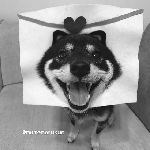

In [268]:
img.convert('L').resize((150,150))

In [270]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

## On le veut sous forme d'une liste de np.arrays

### Exemple de manipulation d'image et résultat sous forme de tableau (numpy array)

In [706]:
np.array(img.resize((1,4))) # Image sur 3 cannaux (R/G/B)

array([[[217, 192, 170]],

       [[ 46,  36,  37]],

       [[177, 108, 113]],

       [[135, 103,  64]]], dtype=uint8)

In [707]:
np.array(img.convert('L').resize((1,4)))

array([[196],
       [ 39],
       [129],
       [108]], dtype=uint8)

In [708]:
test = np.array([1,2,3])

In [709]:
np.expand_dims(test, axis=-1)

array([[1],
       [2],
       [3]])

### Load des photos dans le bon format 

Mais qu'est ce que le format attendu en entrée du réseau de neurones ?

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [8]:
import matplotlib.pyplot as plt

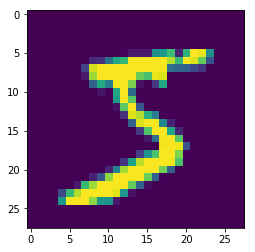

In [9]:
plt.imshow(X_train[0])

In [10]:
y_train[0]

5

From Stackoverflow:

If you look at the Keras documentation, you will observe that for Sequential model's first layers takes the required input. So for example, your first layer is Dense layer with input dimension as 400. Hence each input should be a numpy array of size 400. You can pass a 2D numpy array with size (x,400). (I assume that x is the number of input examples). Your output has 13 dimensions for each output document and hence your final Dense layer has to be model.add(Dense(13)) instead of model.add(Dense(1)).

Coming to how it knows, it takes the first dimension of X as number of training examples and second dimension as the size of each example. Similarly for output layer.

In [6]:
def timeit(method):
    import time
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print( "estimated elapsed time = {}".format(te - ts))
        return result
    return timed

In [7]:
from PIL import Image as hey

In [8]:
@timeit
def load_all_photos(path='', binary_label=[1], number_of_photos=100, to_size=(50,50), channels=1):
    import os, numpy as np
    from PIL import Image
    conversion = 'L' if channels==1 else 'RGB' 
    data = []
    for image in os.listdir(path)[:number_of_photos]:
        try:
            data.append( 
                np.array(Image.open(path+image).convert(conversion).resize(to_size, Image.ANTIALIAS))
            )
        except:
            continue
    return np.array(data), np.array( binary_label* len(data))

In [9]:
X_dogs, y_dogs = load_all_photos('data_hakitainu/', [1], 4500, (150,150), 3 )
X_cats, y_cats = load_all_photos('data_meandbeardedones//', [0], 5500, (150,150), 3)

estimated elapsed time = 7.4208900928497314
estimated elapsed time = 9.451065063476562


In [12]:
X = np.concatenate((X_dogs, X_cats))
y = np.concatenate((y_dogs, y_cats))

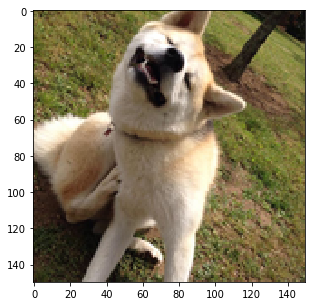

In [1753]:
plt.imshow(X[1], cmap='gist_gray')

## 3. Prepare dataset 

In [13]:
def split(X, y, train_size = 0.7):
    """ Randomly split the train and test sets from data according to train_size ratio """
    import random, numpy as np
    assert len(X) == len(y)
    ## choose k unique randoms elements from sequence range(len(data))
    train_choices = random.sample(population=range(len(X)), 
                                      k=round(train_size*len(X)))
    ## take the previously unselected rest as test sample
    test_choices = list( set(range(len(X))) - set(train_choices) )
    
    return X[train_choices],y[train_choices],\
            X[test_choices], y[test_choices]

In [14]:
X_train, y_train, X_test, y_test = split(X, y, train_size=0.75)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((860, 150, 150, 3), (860,), (286, 150, 150, 3), (286,))

(<matplotlib.image.AxesImage at 0xc79813208>, 0)

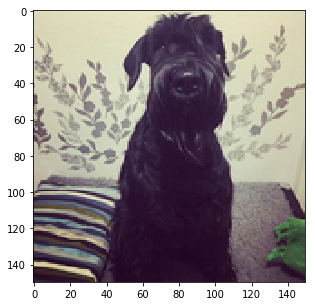

In [1757]:
plt.imshow(X_train[4], cmap='gist_gray'), y_train[5]

In [1742]:
x_train = np.random.random((5, 2))

In [1743]:
x_train

array([[0.49398235, 0.74465873],
       [0.12541179, 0.67615264],
       [0.89667015, 0.24162421],
       [0.69285993, 0.55407612],
       [0.05090963, 0.54598356]])

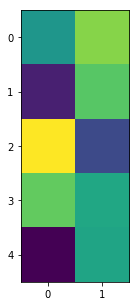

In [1744]:
plt.imshow(x_train)

## NOTATIONS VECTEURS MATRICES ET MATRICE DES POIDS NOTAMMENT + Rappels

<img src='TD6_ressources/DotProduct.png' width=500 align='center'>

<img src='TD6_ressources/PropertiesDotProduct_English.png'>

*** Matrix multiplication *** of (m rows, n columns) with (n rows, l columns)
* m x n \* n x l   => m x l
* 1 x n \* n x l   => 1 x l => **X** \* **W_(ij)** (then nrows for n neurons)

X is a vector identified as 1-row matrice

h = sigma ( **X_(1i)** \* **W_(ij)** )   with i = ith neuron from first layer to j = jth neuron from 2nd layer ( 1 x n \* n x l )

comme t(t(A)) = A 

=>

h = sigma ( **W_(ij)^t** \* **X_(1i)**^t )

<=> h = sigma ( **W_(ji)** \* **X_(i1)** )

## 2. Create a simple CNN model using high-level Keras library

In [17]:
## 2. Create a simple CNN model using high-level Keras library
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD

In [20]:
def keras_model(input_shape=(150,150,3)):
    """ VGG-like convnet — according to https://keras.io/getting-started/sequential-model-guide/#specifying-the-input-shape"""
    model = Sequential()
    # input: 150x150 images with 1 channels -> (150, 150, 1) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25)) # 25% to be dropped = leaving 75% of the fraction inputs neurons

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [21]:
model = keras_model()

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 70, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 68, 68, 64)        36928     
__________

#### First Conv2D
* **for image input channels == 3**
   - 32 filters for each channel (*3) = 96
   - 32 bias 
   - 3*3 = 9 weights per filter
   - TOTAL : 864 + 32 = 896 params
* **for image input channels == 1**
 
   - 32 filters for each channel (*1) = 32
   - 32 bias 
   - 3*3 = 9 weights per filter
   - TOTAL : 288 + 32 = 320 params

#### Second Conv2D
***Does not depend on input image size***
   - 32 filters here
   - 32 bias 
   - 3*3 = 9 weights per filter
   - TOTAL : 3 * 3 * 32 * (32 of the previous layer) + 32 = 9248 params 

#### Dense layer 
 - (34 \* 34 \* 64) (image size outputing = number of neurons after convolutions previously flattened) x 256 + 256 

### 2.1. A few things about Dropout & Conv2D layers

<img src='TD6_ressources/3_channels_Conv2DLayer.png' width=800 align='left'>

<img src='TD6_ressources/DropoutScheme.png' width=800 align='left'>

### 2.2 Fitting the model to the training data

In [23]:
X_train.shape

(860, 150, 150, 3)

In [1763]:
history = model.fit(x=X_train, y=y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=3, 
                    batch_size=8)

Train on 860 samples, validate on 286 samples
Epoch 1/3
860/860 [==============================] - 49s 57ms/step - loss: 1.3451 - val_loss: 1.3990
Epoch 2/3
860/860 [==============================] - 45s 53ms/step - loss: 0.6957 - val_loss: 2.5359
Epoch 3/3
860/860 [==============================] - 43s 50ms/step - loss: 0.3297 - val_loss: 0.5917


In [1765]:
history.history

{'val_loss': [1.398978826882956, 2.535896276677405, 0.5917165299708192],
 'loss': [1.3451245061879935, 0.6956748961362728, 0.32974587744751643]}

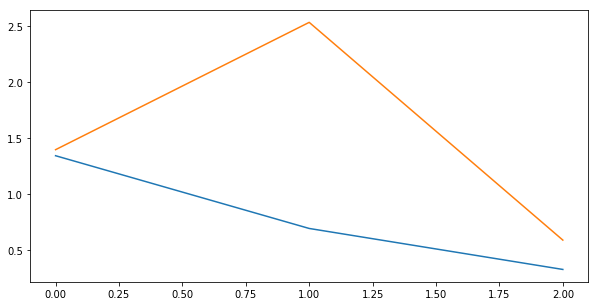

In [1766]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [1785]:
score = model.evaluate(X_test, y_test, batch_size=32)

286/286 [==============================] - 4s 13ms/step


In [1786]:
score

0.5917165391928666

In [1787]:
model.metrics_names

['loss']

### 2.3 Are those results good ?

when loss for binary cross entropy is 0.693 in absolute value => means that <=> ln(0.5)
=> there is 50/50 probability to find the correct label ... and this is bad... really bad

** Let's have a check : **

In [1790]:
predictions = model.predict_classes(X_test)

In [1793]:
df  = pd.DataFrame(predictions, columns=['predictions'])
df['y_test'] = y_test
df['equals'] = df["y_test"] == df['predictions'] # When predicted class is the same as the true one

### 2.3.1 Confusion Matrix

Application of an interpretable classification model on Early Folding Residues during protein folding - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Confusion-matrix-Exemplified-CM-with-the-formulas-of-precision-PR-recall-RE_fig1_330174519 [accessed 2 Nov, 2019]

Fig. 2 Confusion matrix. Exemplified CM with the formulas of precision (PR), recall (RE), accuracy (CA), and F 1-measurea

<img src='td6_ressources/confusion_matrix2.png' width=800 align='left'>

### 2.3.1 Accuracy

Mémo pour se souvenir : 
* Accuracy = (tout ce qui matche ) / (tous les échantillons)

In [1803]:
from collections import Counter

In [1804]:
results = Counter(df.predictions == df.y_test)
results

Counter({True: 224, False: 62})

In [1805]:
results[True] / (results[False] + results[True])

0.7832167832167832

... not bad

### 2.3.2 Recall 

Les positifs trouvés par le modèle VS tous les positifs  (=> pénalise quand le modèle ne trouve rien)

<img src='td6_ressources/confusion_matrix2.png' width=800 align='left'>

In [1811]:
True_positives =  df[ (df['predictions'] == 1)  & (df['y_test'] == 1) ]

In [1812]:
False_negatives = df[ (df['predictions'] == 0)  & (df['y_test'] == 1) ]

In [1813]:
len(True_positives) / ( len (True_positives) + len(False_negatives) )

0.6746031746031746

it's ok...

### 2.4 Normalizing inputs

In [30]:
def resize_all(array_images, size=(50, 50)):
    """resize one input image array """
    import cv2, numpy as np
    return np.array([   cv2.resize(image, dsize=size) for image in array_images   ])

In [31]:
def normalize(array_image, RGB_range_01=False):
    """normalize one input image array """
    if not RGB_range_01:
        array_image = array_image/255
    return ( array_image - array_image.mean() ) / ( array_image.std()+0.00000001)

In [32]:
def normalize_all(array_images, RGB_range_01=False):
    return np.array([normalize(image, RGB_range_01) for image in array_images])

In [33]:
normalize(np.array([[2,3,4], [2,2,2]]), RGB_range_01=False)

array([[-0.65465149,  0.65465149,  1.96395446],
       [-0.65465149, -0.65465149, -0.65465149]])

In [34]:
X_train_normalized = normalize_all(resize_all(X_train, (150,150)))
X_test_normalized = normalize_all(resize_all(X_test, (150,150)))

In [35]:
X_train_normalized.shape, X_test_normalized.shape, y_train.shape, y_test.shape

((860, 150, 150, 3), (286, 150, 150, 3), (860,), (286,))

In [36]:
model_normalized_input = keras_model(input_shape=(150,150,3))

In [37]:
X_train_normalized.shape, X_test_normalized.shape, y_train.shape, y_test.shape

((860, 150, 150, 3), (286, 150, 150, 3), (860,), (286,))

### 2.5 Using EarlyStopping and ModelCheckpoint to prevent overfitting

In [27]:
from keras.callbacks import EarlyStopping
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint

In [25]:
checkpoint = ModelCheckpoint(filepath="best_model_normalised_input.hdf5", 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

In [26]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

In [71]:
df_weights = {}
def save_weights(epoch, logs):
    df_weights[epoch] = model.layers[0].get_weights()[0][:,:,:,0])

In [72]:
callback = LambdaCallback(on_epoch_end=save_weights)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


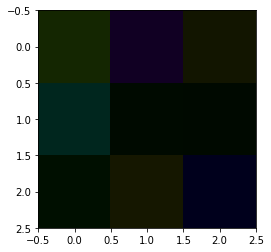

In [113]:
plt.imshow(model_normalized_input.layers[0].get_weights()[0][:,:,:,0])

In [76]:
history = model_normalized_input.fit(x=X_train_normalized, y=y_train, 
                    validation_data=(X_test_normalized, y_test), 
                    epochs=15, 
                    batch_size=4, 
                    callbacks=[checkpoint, callback, es])

Train on 860 samples, validate on 286 samples
Epoch 1/15
860/860 [==============================] - 57s 66ms/step - loss: 1.5833 - val_loss: 1.5307

Epoch 00001: val_loss improved from inf to 1.53071, saving model to best_model_normalised_input.hdf5
Epoch 2/15
860/860 [==============================] - 57s 66ms/step - loss: 0.6621 - val_loss: 0.6194

Epoch 00002: val_loss improved from 1.53071 to 0.61943, saving model to best_model_normalised_input.hdf5
Epoch 3/15
860/860 [==============================] - 55s 64ms/step - loss: 0.4116 - val_loss: 0.5397

Epoch 00003: val_loss improved from 0.61943 to 0.53975, saving model to best_model_normalised_input.hdf5
Epoch 4/15
860/860 [==============================] - 54s 63ms/step - loss: 0.2466 - val_loss: 0.9175

Epoch 00004: val_loss did not improve from 0.53975
Epoch 5/15
860/860 [==============================] - 54s 63ms/step - loss: 0.1736 - val_loss: 0.6875

Epoch 00005: val_loss did not improve from 0.53975
Restoring model weights fr

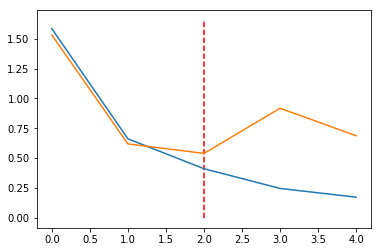

In [96]:
# Example using early stopping
plt.plot(model_normalized_input.history.history['loss'])
plt.plot(model_normalized_input.history.history['val_loss'])
plt.vlines(x=2, ymin=0, ymax=plt.axis()[-1], linestyles='--', color='r')

In [101]:
model_normalized_input.evaluate(X_test_normalized, y_test)

286/286 [==============================] - 4s 14ms/step


0.5397496694451446

In [104]:
df_weights

{0: array([[[ 0.12666802, -0.12250451, -0.01113261],
         [ 0.0375074 ,  0.04364346, -0.11065039],
         [ 0.1339614 ,  0.02176566,  0.09928879]],
 
        [[ 0.1119532 , -0.05707024,  0.09886546],
         [ 0.11780481, -0.13797168,  0.12727894],
         [ 0.10902314,  0.00502662, -0.07632457]],
 
        [[-0.04435411, -0.06404815, -0.02775873],
         [ 0.08703025, -0.00817838, -0.02317909],
         [ 0.03730614,  0.0004933 ,  0.09172218]]], dtype=float32),
 1: array([[[ 0.12666802, -0.12250451, -0.01113261],
         [ 0.0375074 ,  0.04364346, -0.11065039],
         [ 0.1339614 ,  0.02176566,  0.09928879]],
 
        [[ 0.1119532 , -0.05707024,  0.09886546],
         [ 0.11780481, -0.13797168,  0.12727894],
         [ 0.10902314,  0.00502662, -0.07632457]],
 
        [[-0.04435411, -0.06404815, -0.02775873],
         [ 0.08703025, -0.00817838, -0.02317909],
         [ 0.03730614,  0.0004933 ,  0.09172218]]], dtype=float32),
 2: array([[[ 0.12666802, -0.12250451, -0.0111

In [181]:
from keras import Model

In [200]:
intermediate_model = Model(inputs=model_normalized_input.layers[0].input, 
                           outputs=[l.output for l in model_normalized_input.layers])
results_imgs = intermediate_model.predict(X_test_normalized)

In [202]:
[result.shape for result in results_imgs]

[(286, 148, 148, 32),
 (286, 74, 74, 32),
 (286, 72, 72, 32),
 (286, 72, 72, 32),
 (286, 72, 72, 32),
 (286, 70, 70, 64),
 (286, 68, 68, 64),
 (286, 17, 17, 64),
 (286, 17, 17, 64),
 (286, 17, 17, 64),
 (286, 18496),
 (286, 256),
 (286, 256),
 (286, 256),
 (286, 1)]

In [204]:
model_normalized_input.layers # 1,2,3,6,7,8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


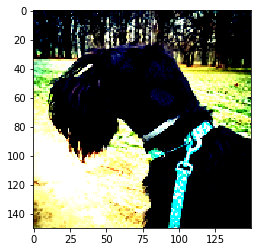

In [301]:
plt.imshow(X_test_normalized[25])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


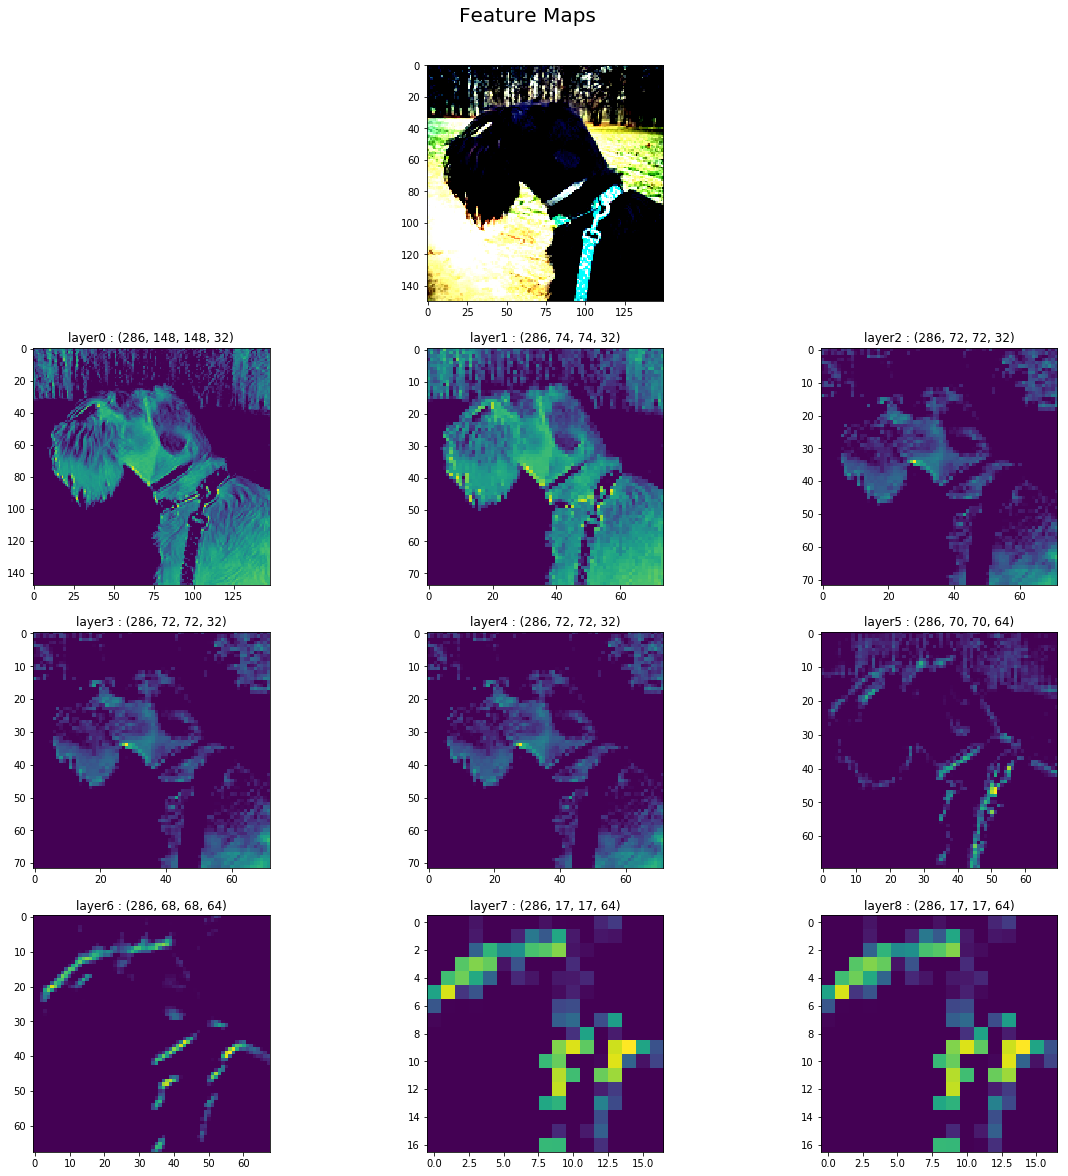

In [370]:
from matplotlib import gridspec
gs = gridspec.GridSpec(4, 3)
fig, axes = plt.subplots(figsize=(20,20))
fig.suptitle('Feature Maps', fontsize=20, x=0.5, y=0.92)
ax = plt.subplot(gs[0, 1])
ax.imshow(X_test_normalized[25])
for i_ in range(0,9):
    ax = plt.subplot(gs[3+i_])
    ax.imshow(results_imgs[i_][25,...,1])
    ax.set_title('layer{} : {}'.format(i_, str(results_imgs[i_].shape)))
plt.savefig('td6_ressources/FeatureMaps.png')

## Best model was saved accordingly

In [ ]:
model_normalized_input.

In [ ]:
#### Loading best model, compiling it, and fitting with same training data but different batch size

In [1861]:
from keras.models import load_model

In [1862]:
model_normalized_saved = load_model("best_model_normalised_input.hdf5")

Let's take accuracy rather than loss

In [1863]:
model_normalized_saved.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [1864]:
checkpoint = ModelCheckpoint('best_model_from_normalized_ones_fitting.hdf5', 
                             monitor='val_acc', mode='max', save_best_only=True,
                             period=1, verbose=1)

In [1865]:
history = model_normalized_saved.fit(x=X_train_normalized, y=y_train, 
                                     validation_data=(X_test_normalized, y_test), 
                                     batch_size=2, epochs=10, shuffle=True, 
                                     callbacks=[checkpoint])

Train on 860 samples, validate on 286 samples
Epoch 1/10
860/860 [==============================] - 73s 85ms/step - loss: 0.8315 - acc: 0.7000 - val_loss: 0.6487 - val_acc: 0.7308

Epoch 00001: val_acc improved from -inf to 0.73077, saving model to best_model_from_normalized_ones_fitting.hdf5
Epoch 2/10
860/860 [==============================] - 66s 77ms/step - loss: 0.5348 - acc: 0.7570 - val_loss: 0.7436 - val_acc: 0.6538

Epoch 00002: val_acc did not improve from 0.73077
Epoch 3/10
860/860 [==============================] - 67s 78ms/step - loss: 0.4339 - acc: 0.8174 - val_loss: 0.4430 - val_acc: 0.7692

Epoch 00003: val_acc improved from 0.73077 to 0.76923, saving model to best_model_from_normalized_ones_fitting.hdf5
Epoch 4/10
860/860 [==============================] - 67s 78ms/step - loss: 0.2870 - acc: 0.8826 - val_loss: 0.4186 - val_acc: 0.8357

Epoch 00004: val_acc improved from 0.76923 to 0.83566, saving model to best_model_from_normalized_ones_fitting.hdf5
Epoch 5/10
860/860 

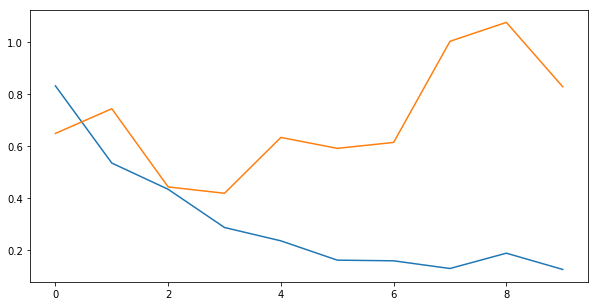

In [1866]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [1869]:
model_ = load_model("best_model_from_normalized_ones_fitting.hdf5")

In [1870]:
model_.evaluate(X_test_normalized, y_test)

286/286 [==============================] - 6s 21ms/step


[0.4185984249298389, 0.8356643335802572]

on retrouve bien le val_loss précédent au moment où le modèle avait été enregistré

## Final validation data

In [1873]:
X_VALID_1, y_VALID_1 = load_all_photos('data_odai/',    [1], 100, (150, 150), channels=3)
X_VALID_0, y_VALID_0 = load_all_photos('data_zezette/', [0], 100, (150, 150), channels=3)
X_VALID = np.concatenate([X_VALID_0, X_VALID_1])
y_VALID = np.concatenate([y_VALID_0, y_VALID_1])

X_VALID_normalized = normalize(X_VALID)

estimated elapsed time = 1.7303450107574463
estimated elapsed time = 2.7729668617248535


## 3.0 TRANSFER_LEARNING // Using pre-trained model (VGG with ImageNet) 

In [1886]:
VGG19_model = keras.applications.VGG19(weights = "imagenet", 
                           include_top=False, 
                           input_shape = (150, 150, 3))

In [1887]:
VGG19_model.layers

In [1888]:
# freeze feature layers and rebuild model
for l in VGG19_model.layers:
    l.trainable = False

Define the classification layers 

In [1889]:
classification_layers = [
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
]

In [1890]:
model_using_pre_trained_one = Sequential( VGG19_model.layers + classification_layers )

In [1891]:
for l in model_using_pre_trained_one.layers:
    print( l.trainable )

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [1892]:
model_using_pre_trained_one.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [1893]:
model_using_pre_trained_one.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

In [1894]:
history = model_using_pre_trained_one.fit(
                            x = X_train_normalized, y=y_train,
                            validation_data=(X_test_normalized, y_test),
                            batch_size=1, epochs=5, 
                            shuffle=True)

Train on 860 samples, validate on 286 samples
Epoch 1/5
860/860 [==============================] - 173s 201ms/step - loss: 0.3961 - acc: 0.8430 - val_loss: 0.2477 - val_acc: 0.8986
Epoch 2/5
860/860 [==============================] - 166s 193ms/step - loss: 0.1754 - acc: 0.9372 - val_loss: 0.1832 - val_acc: 0.9056
Epoch 3/5
860/860 [==============================] - 166s 193ms/step - loss: 0.1289 - acc: 0.9430 - val_loss: 0.1912 - val_acc: 0.9161
Epoch 4/5
860/860 [==============================] - 166s 193ms/step - loss: 0.0515 - acc: 0.9791 - val_loss: 0.2139 - val_acc: 0.9231
Epoch 5/5
860/860 [==============================] - 176s 204ms/step - loss: 0.1005 - acc: 0.9674 - val_loss: 0.3054 - val_acc: 0.9126


In [1895]:
model_using_pre_trained_one.evaluate(X_VALID_normalized, y_VALID)

59/59 [==============================] - 7s 121ms/step


[1.492148803452314, 0.6101695036484023]

In [1898]:
results_odai = model_using_pre_trained_one.predict_classes( 
    normalize_all( load_all_photos(  'data_odai/',  [1],  100, (150, 150), 3 )[0] )
)

estimated elapsed time = 1.7849960327148438


In [1899]:
results_zezette = model_using_pre_trained_one.predict_classes( 
    normalize_all( load_all_photos(  'data_zezette/',  [0],  100, (150, 150), 3 )[0] ) 
)

estimated elapsed time = 2.835684061050415


In [1900]:
sum(Counter(results_odai.flatten()).values())

42

In [1901]:
sum(Counter(results_zezette.flatten()).values())

17

In [1902]:
Counter(results_odai.flatten())

Counter({0: 19, 1: 23})

In [1903]:
Counter(results_zezette.flatten())

Counter({0: 14, 1: 3})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


estimated elapsed time = 1.7569241523742676


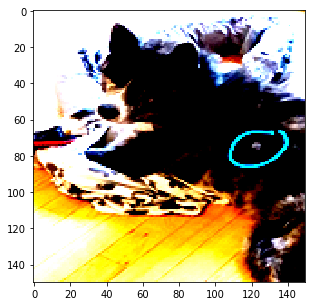

In [1904]:
plt.imshow(    normalize( load_all_photos(  'data_odai/',  [0],  100, (150, 150), 3 )[0] )[2]    )

# Fin.